In [21]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

In [3]:
# Paths
data_path = "C:/data"
model_path = "C:/models"

# Load test features and model
train_features = pd.read_pickle(f"{data_path}/train_features.pkl")
test_features = pd.read_pickle(f"{data_path}/test_features.pkl")


rf_model = joblib.load(f"{model_path}/rf_model.pkl")
gbr_model = joblib.load(f"{model_path}/gbr_model.pkl")

In [5]:
categorical_cols = ['Driver', 'Compound']

train_encoded = pd.get_dummies(train_features, columns=categorical_cols, drop_first=True)
test_encoded = pd.get_dummies(test_features, columns=categorical_cols, drop_first=True)

# Re-align test_encoded columns to match train_encoded
test_encoded = test_encoded.reindex(columns=train_encoded.columns, fill_value=0)


## Predicted vs Actual Values

In [7]:
driver = "VER"

driver_test_features = test_features[test_features['Driver'] == driver].copy()
driver_test_features = driver_test_features.sort_values('LapNumber')

driver_test_encoded = test_encoded.loc[driver_test_features.index].copy()

driver_predictions = gbr_model.predict(driver_test_encoded.drop("LapTimeSeconds", axis=1))

lap_numbers = driver_test_features["LapNumber"].values
actual_lap_times = driver_test_features["LapTimeSeconds"].values

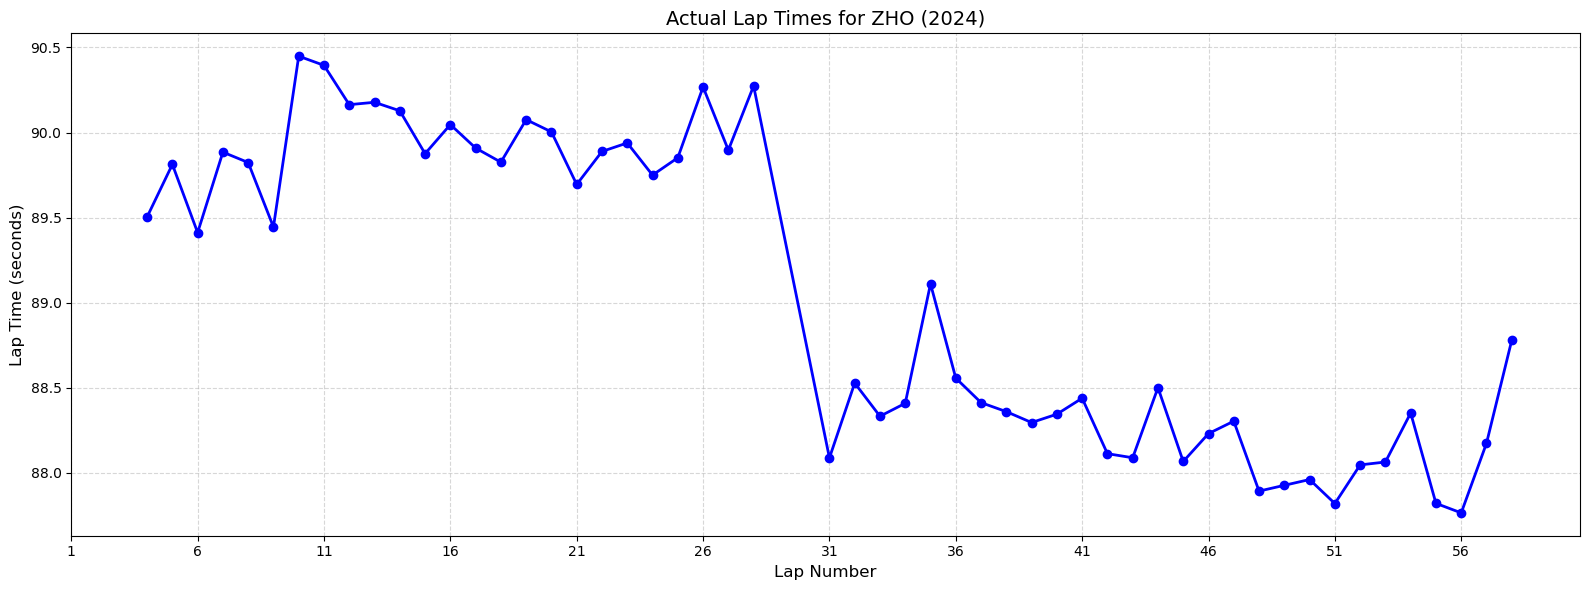

In [48]:
plt.figure(figsize=(16, 6))
plt.plot(lap_numbers, actual_lap_times, marker='o', linestyle='-', color='blue', linewidth=2)
plt.title(f"Actual Lap Times for {driver} (2024)", fontsize=14)
plt.xlabel("Lap Number", fontsize=12)
plt.ylabel("Lap Time (seconds)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(1, int(max(lap_numbers)), 5))
plt.tight_layout()
plt.savefig("C:/visuals/actual_laptimes_ver.png", dpi=300, bbox_inches='tight')
plt.show()

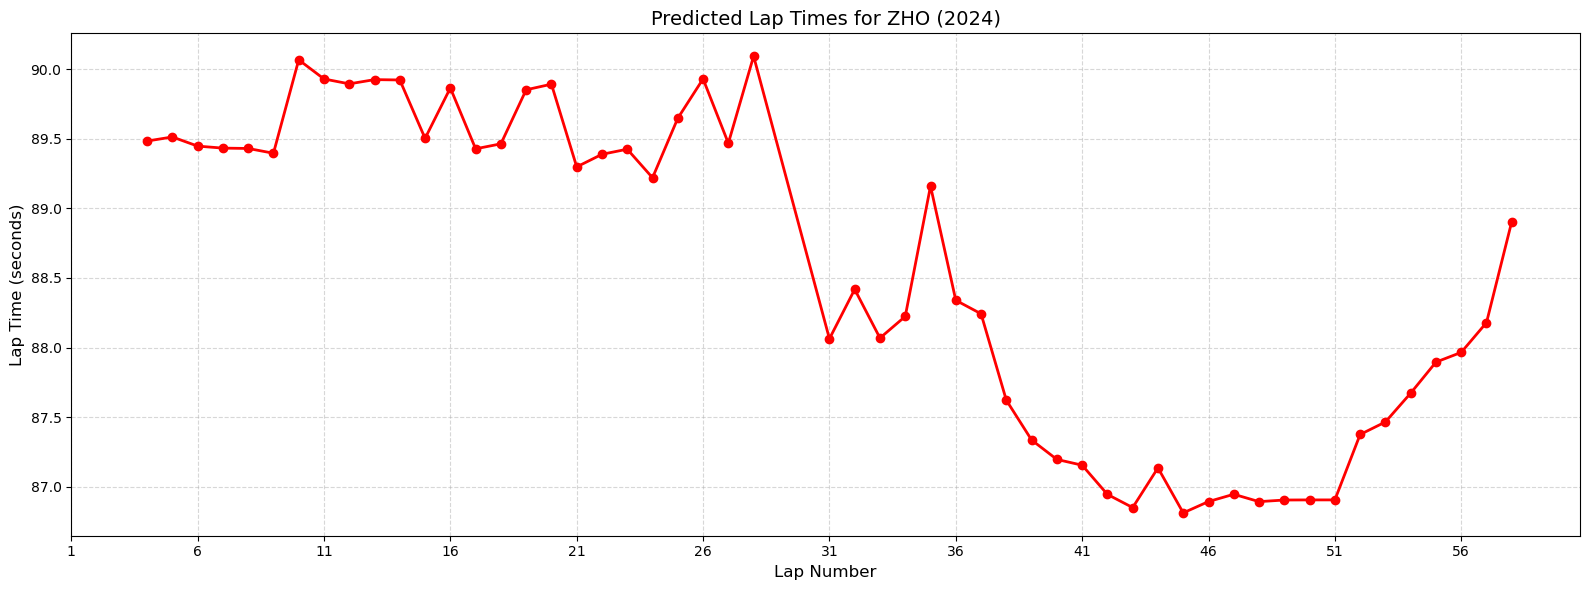

In [50]:
plt.figure(figsize=(16, 6))
plt.plot(lap_numbers, driver_predictions, marker='o', linestyle='-', color='red', linewidth=2)
plt.title(f"Predicted Lap Times for {driver} (2024)", fontsize=14)
plt.xlabel("Lap Number", fontsize=12)
plt.ylabel("Lap Time (seconds)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.xticks(range(1, int(max(lap_numbers)), 5))
plt.tight_layout()
plt.savefig("C:/visuals/predicted_laptimes_ver.png", dpi=300, bbox_inches='tight')
plt.show()

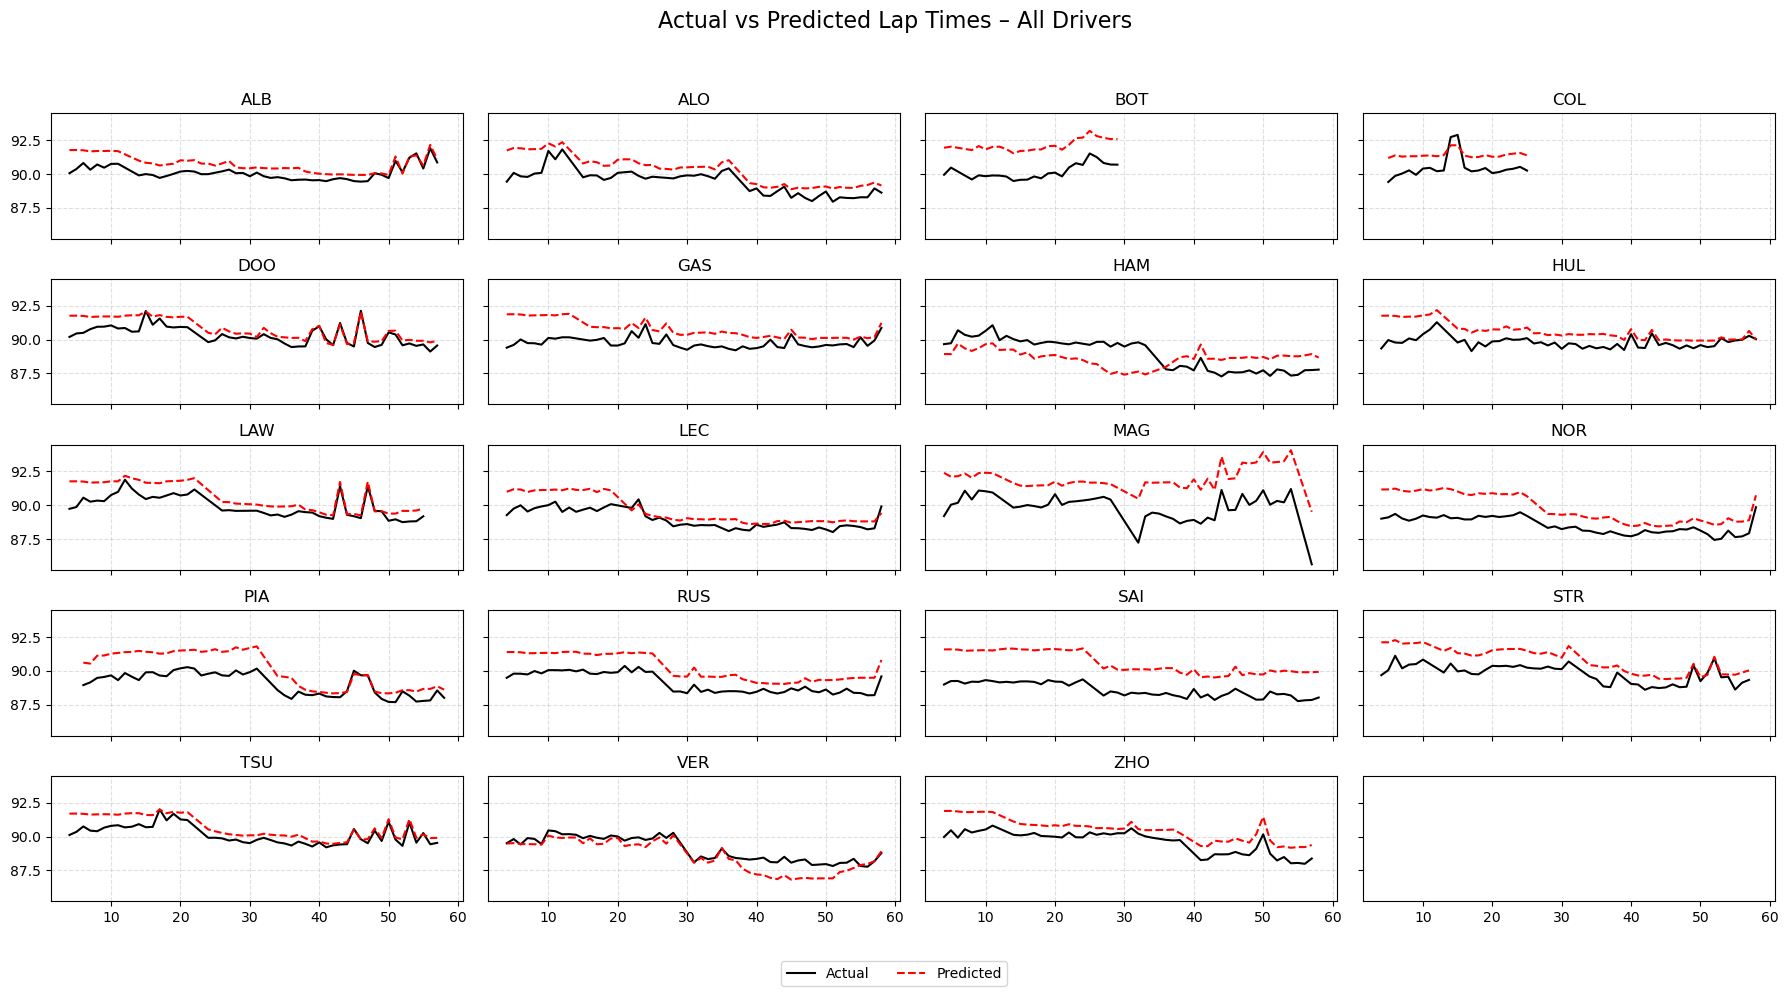

In [52]:
unique_drivers = sorted(test_features['Driver'].unique())
cols = 4
rows = int(np.ceil(len(unique_drivers) / cols))

fig, axes = plt.subplots(rows, cols, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i, driver in enumerate(unique_drivers):
    df_driver = test_features[test_features['Driver'] == driver].copy()
    df_driver = df_driver.sort_values("LapNumber")
    encoded_driver = test_encoded.loc[df_driver.index]
    
    y_true = df_driver["LapTimeSeconds"].values
    y_pred = gbr_model.predict(encoded_driver.drop("LapTimeSeconds", axis=1))
    laps = df_driver["LapNumber"].values

    axes[i].plot(laps, y_true, label="Actual", color='black', linewidth=1.5)
    axes[i].plot(laps, y_pred, label="Predicted", linestyle='--', color='red')
    axes[i].set_title(driver)
    axes[i].grid(True, linestyle='--', alpha=0.4)

# Legend on outside
fig.suptitle("Actual vs Predicted Lap Times – All Drivers", fontsize=16)
fig.legend(["Actual", "Predicted"], loc='lower center', ncol=2)
plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.savefig("C:/visuals/laptimes_drivers.png", dpi=300, bbox_inches='tight')
plt.show()

## Deviation plot

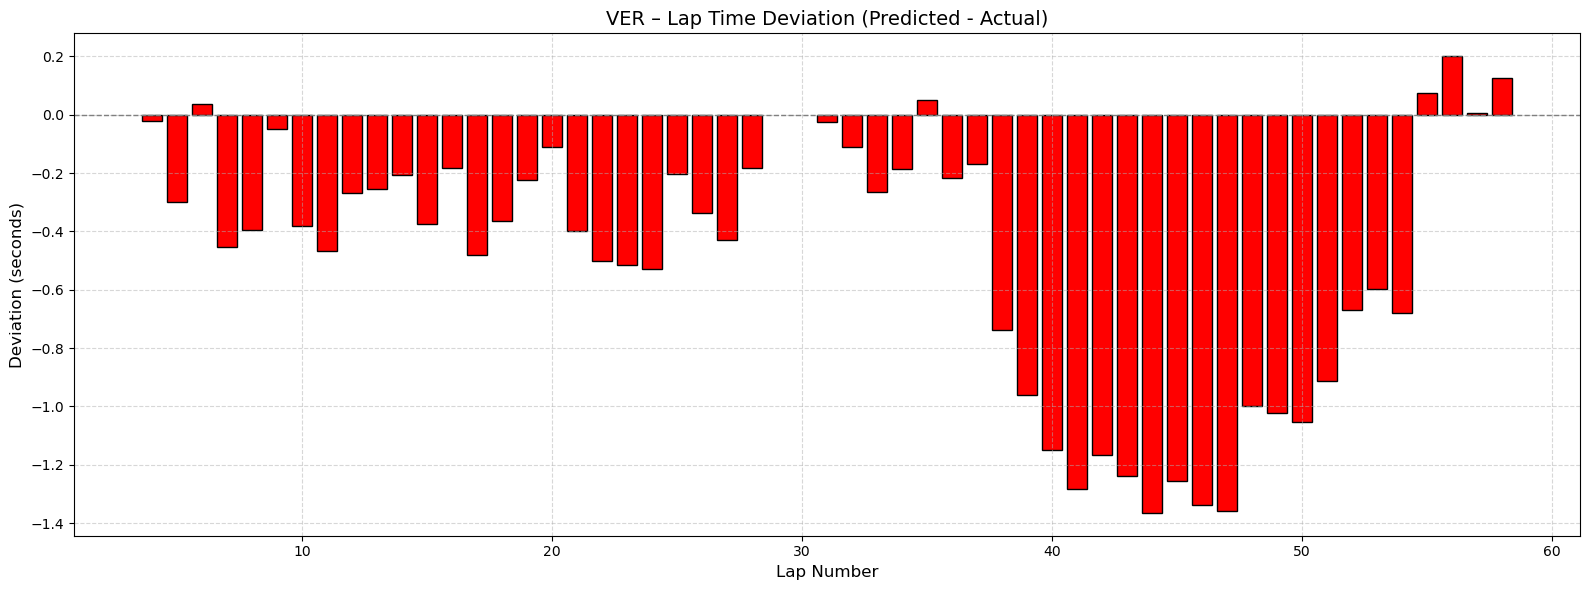

In [53]:
# Driver setup
driver = "VER"

# Calculate deviation
deviation = driver_predictions - actual_lap_times  # +ve = overestimate, -ve = underestimate

# Plot deviation
plt.figure(figsize=(16, 6))
plt.bar(lap_numbers, deviation, color='red', edgecolor='black')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)
plt.title(f"{driver} – Lap Time Deviation (Predicted - Actual)", fontsize=14)
plt.xlabel("Lap Number", fontsize=12)
plt.ylabel("Deviation (seconds)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("C:/visuals/deviation_laptimes_ver.png", dpi=300, bbox_inches='tight')
plt.show()

## Deviation Plot per Driver - 2024

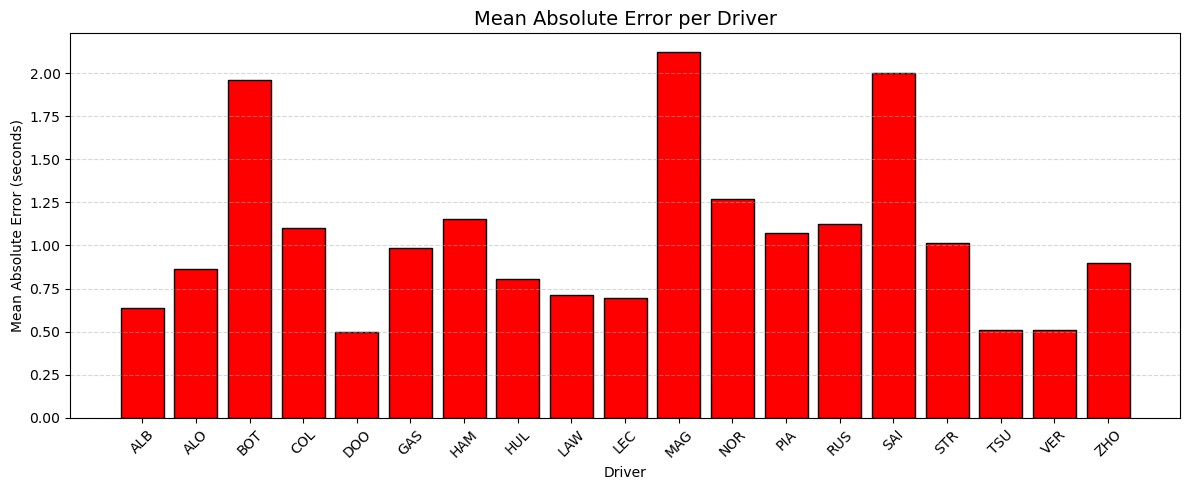

In [56]:
import matplotlib.pyplot as plt

# Get all unique drivers in test_features
drivers = test_features['Driver'].unique()
driver_mae = {}

for driver in drivers:
    df_driver = test_features[test_features['Driver'] == driver].copy()
    df_driver = df_driver.sort_values("LapNumber")
    encoded_driver = test_encoded.loc[df_driver.index]
    
    y_true = df_driver["LapTimeSeconds"].values
    y_pred = gbr_model.predict(encoded_driver.drop("LapTimeSeconds", axis=1))
    
    driver_mae[driver] = np.mean(np.abs(y_true - y_pred))

# Plot
plt.figure(figsize=(12, 5))
plt.bar(driver_mae.keys(), driver_mae.values(), color='red', edgecolor='black')
plt.title("Mean Absolute Error per Driver", fontsize=14)
plt.xlabel("Driver")
plt.ylabel("Mean Absolute Error (seconds)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("C:/visuals/deviation.png", dpi=300, bbox_inches='tight')
plt.show()

## Deviation by tyre compounds

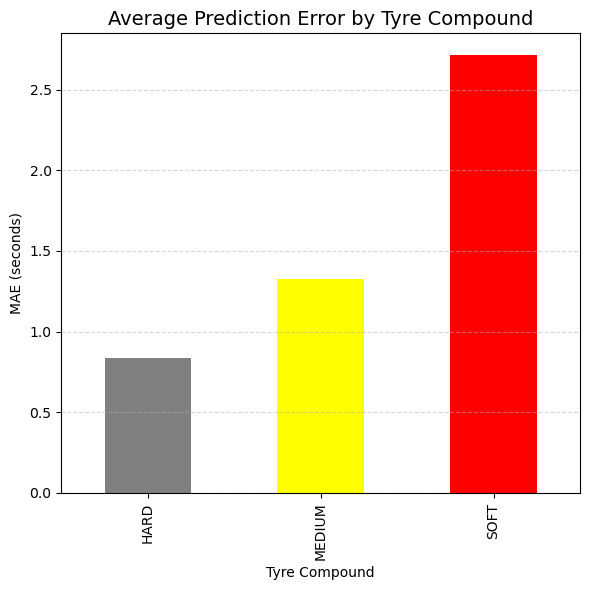

In [58]:
test_features["PredictedLapTime"] = gbr_model.predict(test_encoded.drop("LapTimeSeconds", axis=1))
test_features["Error"] = np.abs(test_features["LapTimeSeconds"] - test_features["PredictedLapTime"])

compound_error = test_features.groupby("Compound")["Error"].mean().sort_values()

plt.figure(figsize=(6, 6))
compound_error.plot(kind='bar', color=["gray", "yellow", "red"])
plt.title("Average Prediction Error by Tyre Compound", fontsize=14)
plt.ylabel("MAE (seconds)")
plt.xlabel("Tyre Compound")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("C:/visuals/deviation_per_compound.png", dpi=300, bbox_inches='tight')
plt.show()